In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm_notebook as tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
# from collections import Counter

## Reading Data

In [0]:
import gdown 
url = 'https://drive.google.com/uc?id=1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9' 
output = 'train.csv' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bDLwb_Vq7q2W9S89JB96PgmZG3LsLns9
To: /content/train.csv
201MB [00:01, 185MB/s]


'train.csv'

In [0]:
import gdown 
url = 'https://drive.google.com/uc?id=14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe' 
output = 'resources.csv' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=14OVXWu_SJU-lJD-jKMOCld14EZ21lYYe
To: /content/resources.csv
127MB [00:00, 161MB/s]


'resources.csv'

In [0]:
project_data = pd.read_csv('train.csv')
resource_data = pd.read_csv('resources.csv')

In [0]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

## Preprocessing of Catogorial data

#### Preprocessing of  project_subject_categories

In [0]:
# The Code had been a refrence form https://www.kaggle.com/rohit0812/rf-gbdt-on-donor-s-choose-data-set
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

#### preprocessing of project_subject_subcategories

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

####  preprocessing of project_grade_category

In [0]:
proj_grade_cat = []

for i in range(len(project_data)):
    pgc = project_data["project_grade_category"][i].replace(" ", "_")
    proj_grade_cat.append(pgc)
    
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data["project_grade_category"] = proj_grade_cat

## 1.1 Text preprocessing

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
def getProcessedData(txt_type, working_data):
    preprocessed_data = []
    # tqdm is for printing the status bar
    
    for sentance in tqdm(working_data[txt_type].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_data.append(sent.lower().strip())
        
    return preprocessed_data

### Preparing data for models
we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

## Machine Learning Model 


### 1.   **SET 1 , I have used the Random Forest Clasifier form SKLearn**


**Set 1**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)
**Set 2**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)
**Set 3**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

**Set 4**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)


### 2.  **SET 2 , I have used the GBDT Classider form SKlearn ( we can also use the XGBoost implimentation)**

**Set 1**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(BOW) + preprocessed_eassay (BOW)
**Set 2**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)
**Set 3**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

**Set 4**: categorical(instead of one hot encoding, try response coding: use probability values), numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)


### 2.1 Response encoding for Categorical data . 


1.   In responce coding we consider the Probaility of the data in accordence to class label 




In [0]:
def trainResponseEncoding(working_data, cat_type): 
    # alpha, the hyperparameter of Laplace smoothing, has been defaulted to 1.
    
    working_data.loc[working_data[cat_type].isnull(), cat_type] = 'nan' #Imputation
    
    data_0 = working_data[working_data['project_is_approved']==0].groupby(cat_type).size()
    data_1 = working_data[working_data['project_is_approved']==1].groupby(cat_type).size()
    
    return data_0, data_1

def getResponseEnconding(data_0, data_1, working_data, cat_type, alpha=1):
    working_data.loc[working_data[cat_type].isnull(), cat_type] = 'nan' #if unseen data with isnull()==True found
    
    colwise_dict = {'col1':[], 'col2': []}
    
    for row in working_data[cat_type]:
        colwise_dict['col1'].append(data_0.get(row, 0.5))
        colwise_dict['col2'].append(data_1.get(row, 0.5))

    class_0 = ((data_0 + alpha)/(data_0 + data_1 + alpha)).values
    class_1 = ((data_1 + alpha)/(data_0 + data_1 + alpha)).values
    
    response_enc = pd.DataFrame(colwise_dict)
    print("Shape response encoding ",response_enc.shape)
    
    return response_enc

In [0]:
#getResponseEncoding(project_data, 'school_state')
#project_data.columns

#### Bag of words Vectorization 

In [0]:
def getFitBOW_Vectorizer(preprocessed_data):
    vectorizer = CountVectorizer(ngram_range=(2,2), max_features=5000, min_df=10)
    vectorizer.fit(preprocessed_data)
    
    return vectorizer

def getBOWVectorizeTxtData(preprocessed_data, vectorizer):
    text_bow = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after one hot encodig ",text_bow.shape)
    
    return text_bow

####  TFIDF vectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

def getFitTFIDF_Vectorizer(preprocessed_data):
    vectorizer = TfidfVectorizer(ngram_range=(2,2), max_features=5000, min_df=10)
    vectorizer.fit(preprocessed_data)
    return vectorizer

def getTFIDFVectorizeTxtData(preprocessed_data, vectorizer):
    text_tfidf = vectorizer.transform(preprocessed_data)
    print("Shape of matrix after one hot encodig ",text_tfidf.shape)
    return text_tfidf

#### 1.5.2.3 Using Pretrained Models: Avg W2V

In [0]:
import gdown
url = 'https://drive.google.com/uc?id=1MqUasf7jYoPbG35MJ28VQcOjjNp-ZDDp'
output = 'glove_vectors' 
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1MqUasf7jYoPbG35MJ28VQcOjjNp-ZDDp
To: /content/glove_vectors
128MB [00:00, 266MB/s]


'glove_vectors'

In [0]:
import pickle 
with open('glove_vectors', 'rb') as f:    
  model = pickle.load(f)    
  glove_words =  set(model.keys())

In [0]:
def getAVG_W2V(preprocessed_data):
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    
    for sentence in tqdm(preprocessed_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)

    print(len(avg_w2v_vectors))
    print(len(avg_w2v_vectors[0]))
    
    return avg_w2v_vectors

####  Using Pretrained Models: TFIDF weighted W2V


In [0]:
def getFitTFIDF_W2V(preprocessed_data):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(preprocessed_data)
    return tfidf_model

In [0]:
def getTFIDF_W2V(preprocessed_data, tfidf_model):
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(preprocessed_data): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)

    print(len(tfidf_w2v_vectors))
    print(len(tfidf_w2v_vectors[0]))
    
    return tfidf_w2v_vectors

###  Vectorizing Numerical features


In [0]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
from sklearn.preprocessing import Normalizer
import warnings 
warnings.filterwarnings("ignore") 

def getFitNUM_Vectorizer(working_data, num_type):
  
    num_scalar = Normalizer()
    num_scalar.fit(working_data[num_type].values.reshape(-1,1)) # finding the mean and standard deviation of this data
    return num_scalar

def getNUM_Vectors(working_data, num_type, num_scalar):
  
    num_standardized = num_scalar.transform(working_data[num_type].values.reshape(-1, 1))
    
    return num_standardized

###  Merging all the above features

In [0]:
from scipy.sparse import hstack

def getMergedFeatures(working_data, merge_on):
    valid_cols = []
    for key, value in working_data.items():
        if key in merge_on:
            valid_cols.append(value)
   
    return hstack(tuple(valid_cols))

##  Applying Random Forest and Gradient Boosting Desion Tress on Different Data models

##  Splitting data into Train and Test : Using Stratified Sampling 

In [0]:
from sklearn.model_selection import train_test_split


X = project_data[:50000]
y = X['project_is_approved']


X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## Encoding Numerical, Categorical Features

In [0]:
data_dict = {'X_tr':{}, 'X_test': {} }
cols_dict = {    'cat_cols': ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category','teacher_prefix'],
                 'num_cols': ['price', 'teacher_number_of_previously_posted_projects']
            }
# 
#'school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix'
for col_type, cols_name in cols_dict.items():
    if col_type == 'cat_cols':
        for cat_type in cols_name:
            print (cat_type)
            data_0, data_1 = trainResponseEncoding(X_tr, cat_type)
            for data_type, data_part in [('X_tr', X_tr), ('X_test', X_test)]:
                response_encode = getResponseEnconding(data_0, data_1, data_part, cat_type)
                data_dict[data_type][cat_type] = response_encode
    else:
        for num_type in cols_name:
            vectorizer = getFitNUM_Vectorizer(X_tr, num_type)
            for data_type, data_part in [('X_tr', X_tr), ('X_test', X_test)]:
                num_vectors = getNUM_Vectors(data_part, num_type, vectorizer)
                data_dict[data_type][num_type] = num_vectors
        

school_state
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
clean_categories
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
clean_subcategories
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
project_grade_category
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)
teacher_prefix
Shape response encoding  (35000, 2)
Shape response encoding  (15000, 2)


## Encoding Eassay and Project_title

In [0]:
for col_type in ['essay','project_title']:
    for data_type, data_part in [('X_tr', X_tr), ('X_test', X_test)]:
        preprocessed_data = getProcessedData(col_type, data_part)
        
        if data_type == 'X_tr':
            vectorizer_bog = getFitBOW_Vectorizer(preprocessed_data)
        text_bow = getBOWVectorizeTxtData(preprocessed_data, vectorizer_bog)
        data_dict[data_type]['%s_text_bow'%col_type] = text_bow
        
        if data_type == 'X_tr':
            vectorizer_tfidf = getFitTFIDF_Vectorizer(preprocessed_data)
        text_tfidf = getTFIDFVectorizeTxtData(preprocessed_data, vectorizer_tfidf)
        data_dict[data_type]['%s_text_tfidf'%col_type] = text_tfidf
        
        text_w2v = getAVG_W2V(preprocessed_data)
        data_dict[data_type]['%s_text_w2v'%col_type] = text_w2v
        
        if data_type == 'X_tr':
            vectorizer_tfidfw2v = getFitTFIDF_W2V(preprocessed_data)
        text_tfidfw2v = getTFIDF_W2V(preprocessed_data, vectorizer_tfidfw2v)
        data_dict[data_type]['%s_text_tfidfw2v'%col_type] = text_tfidfw2v
    


Shape of matrix after one hot encodig  (35000, 5000)
Shape of matrix after one hot encodig  (35000, 5000)



35000
300



35000
300



Shape of matrix after one hot encodig  (15000, 5000)
Shape of matrix after one hot encodig  (15000, 5000)



15000
300



15000
300



Shape of matrix after one hot encodig  (35000, 876)
Shape of matrix after one hot encodig  (35000, 876)



35000
300



35000
300



Shape of matrix after one hot encodig  (15000, 876)
Shape of matrix after one hot encodig  (15000, 876)



15000
300



15000
300


### Applying Random Forest


In [0]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc

In [0]:
def getAUCs(data_pnts_tr, y_tr, parameters, flag=0):
    auc_tr = []
    auc_cv = []
    
    if flag:
        model = xgb.XGBClassifier()
    else:
        model = RandomForestClassifier(class_weight='balanced')

    clf = GridSearchCV(model, param_grid=parameters, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=20)
    clf.fit(data_pnts_tr, y_tr)
    #print (clf)
    auc_tr = clf.cv_results_['mean_train_score']
    auc_tr_std = clf.cv_results_['std_train_score']
    auc_cv = clf.cv_results_['mean_test_score'] 
    auc_cv_std= clf.cv_results_['std_test_score']
    #list(itertools.product(depth, min_samples_split))
    return auc_tr, auc_cv

def plotPerformance3d(hyper1, hyper2, auc_tr1, auc_cv1, plt_title):
    rows = hyper1
    cols = hyper2
    cm_tr = np.array(auc_tr1).reshape((len(rows), len(cols)))
    df_tr = pd.DataFrame(cm_tr, columns=cols, index=rows)
    cm_cv = np.array(auc_cv1).reshape((len(rows), len(cols)))
    df_cv = pd.DataFrame(cm_cv, columns=cols, index=rows)
    
    plt.figure(figsize=(15, 15))

    ax_tr = plt.subplot(221)
    sns.heatmap(df_tr, annot=True, ax=ax_tr, fmt='g')
    ax_tr.set_xlabel('n_estimators')
    ax_tr.set_ylabel('max_depth')
    plt.title("Training data's AUCs on various depth & n_estimators using %s on text features"%plt_title)
    
    ax_cv = plt.subplot(222)
    sns.heatmap(df_cv, annot=True, ax=ax_cv, fmt='g')
    ax_cv.set_xlabel('n_estimators')
    ax_cv.set_ylabel('max_depth')
    plt.title("CV data's AUCs on various depth & n_estimators using %s on text features"%plt_title)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    plt.show()

In [0]:
from sklearn import metrics

def trainOnOptimalHP(optimal_c, X_tr, y_tr, flag=0):
    if flag:
        model = xgb.XGBClassifier()
    else:
        model = RandomForestClassifier(max_depth=optimal_c[0], min_samples_split=optimal_c[1], class_weight='balanced')
    model.fit(X_tr, y_tr)
    return model

def getROC_Data(data_pnts_test, y_test, data_pnts_tr, y_tr, model):
    
    predicted_y_test = model.predict_proba(data_pnts_test)[:, 1]
    predicted_y_tr = model.predict_proba(data_pnts_tr)[:, 1]
    
    fpr_test, tpr_test, thres_test = roc_curve(y_test, predicted_y_test)
    fpr_tr, tpr_tr, thres_tr = roc_curve(y_tr, predicted_y_tr)
    
    return [fpr_test, tpr_test, thres_test], [fpr_tr, tpr_tr, thres_tr]
    
def makeROC(test_data, train_data, plt_title):
    fpr_tr, tpr_tr, _ = train_data
    fpr_test, tpr_test, _ = test_data
    
    plt.plot(fpr_tr, tpr_tr, label='AUC_Train: %s'%auc(train_data[0],train_data[1]))
    plt.plot(fpr_test, tpr_test, label='AUC_Test: : %s'%auc(test_data[0],test_data[1]))
    plt.title("ROC Curve using %s on text features"%plt_title)
    
    plt.xlabel('FPT')
    plt.ylabel('TPR')
    plt.legend()
    

In [0]:
#Reference: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
#fmt='g' reason: https://stackoverflow.com/questions/29647749/seaborn-showing-scientific-notation-in-heatmap-for-3-digit-numbers
from sklearn.metrics import confusion_matrix

def getConfusionMatrix(svm, data_pnts_test, y_true, plt_title):
    y_pred = svm.predict(data_pnts_test)
    
    cm = confusion_matrix(y_true, y_pred) # Predicted values are column wise!
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='g')
    
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('Actual Labels')
    ax.set_title('Confusion Matrix using %s on text features'%plt_title)
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    

In [0]:
rf_n_estimators = [10, 100, 500] 
rf_max_depths =  [10, 50, 100, 500, 1000]
rf_parameters = {  'max_depth': rf_max_depths, 
                    'n_estimators': rf_n_estimators }
                #'return_train_score': True }

### Random Forest on BOW SET :1 

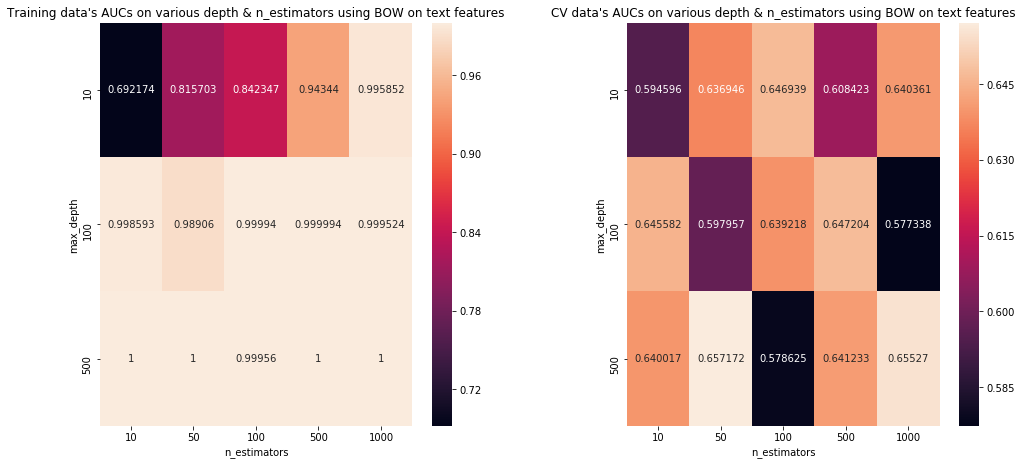

In [0]:
rf_set1_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_bow', 'project_title_text_bow']
rf_plt_title1 = 'BOW'

rf_data_pnts_tr1 = getMergedFeatures(data_dict['X_tr'], rf_set1_cols)
rf_data_pnts_test1 = getMergedFeatures(data_dict['X_test'], rf_set1_cols)

rf_auc_tr1, rf_auc_cv1 = getAUCs(rf_data_pnts_tr1, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr1, rf_auc_cv1, rf_plt_title1)
rf_optimal_hypers1 = (10, 50)
rft1 = trainOnOptimalHP(rf_optimal_hypers1, rf_data_pnts_tr1, y_tr)
rf_roc_data_test1, rf_roc_data_train1 = getROC_Data(rf_data_pnts_test1, y_test, rf_data_pnts_tr1, y_tr, rft1)

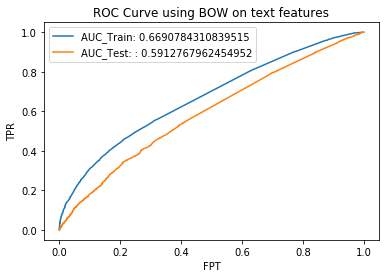

In [0]:
makeROC(rf_roc_data_test1, rf_roc_data_train1, rf_plt_title1)

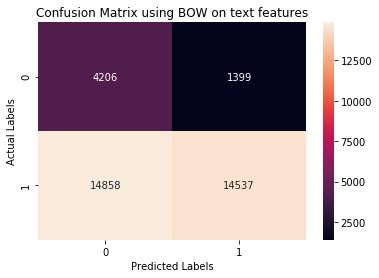

In [0]:
getConfusionMatrix(rft1, rf_data_pnts_tr1, y_tr, rf_plt_title1)

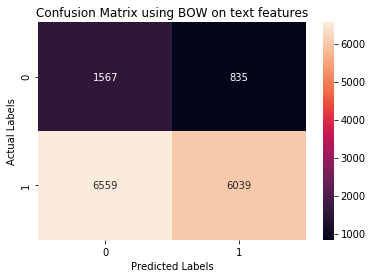

In [0]:
getConfusionMatrix(rft1, rf_data_pnts_test1, y_test, rf_plt_title1)

### RF on TFIDF  SET 2

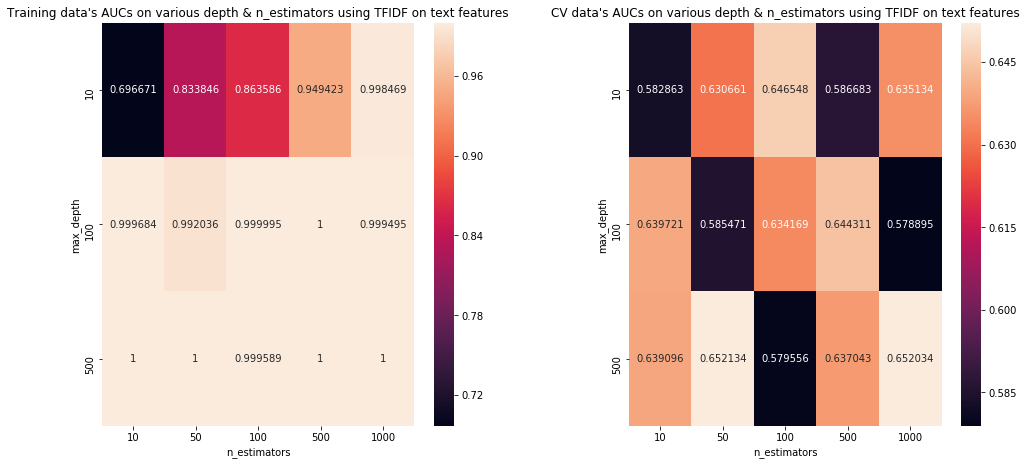

In [0]:
rf_set2_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidf', 'project_title_text_tfidf']
rf_plt_title2 = 'TFIDF'

rf_data_pnts_tr2 = getMergedFeatures(data_dict['X_tr'], rf_set2_cols)
rf_data_pnts_test2 = getMergedFeatures(data_dict['X_test'], rf_set2_cols)

rf_auc_tr2, rf_auc_cv2 = getAUCs(rf_data_pnts_tr2, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr2, rf_auc_cv2, rf_plt_title2)
rf_optimal_alpha2 = (10, 50)
rft2 = trainOnOptimalHP(rf_optimal_alpha2, rf_data_pnts_tr2, y_tr)
rf_roc_data_test2, rf_roc_data_train2 = getROC_Data(rf_data_pnts_test2, y_test, rf_data_pnts_tr2, y_tr, rft2)

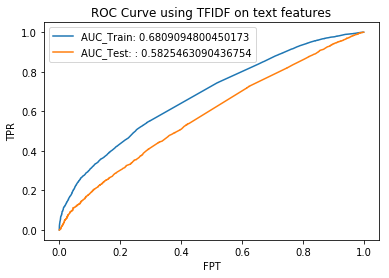

In [0]:
makeROC(rf_roc_data_test2, rf_roc_data_train2, rf_plt_title2)

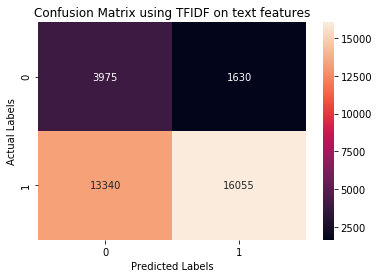

In [0]:
getConfusionMatrix(rft2, rf_data_pnts_tr2, y_tr, rf_plt_title2)

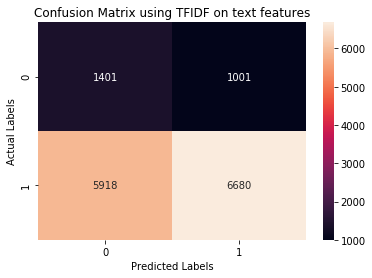

In [0]:
getConfusionMatrix(rft2, rf_data_pnts_test2, y_test, rf_plt_title2)

### Applying RF on AVG W2V, SET 3

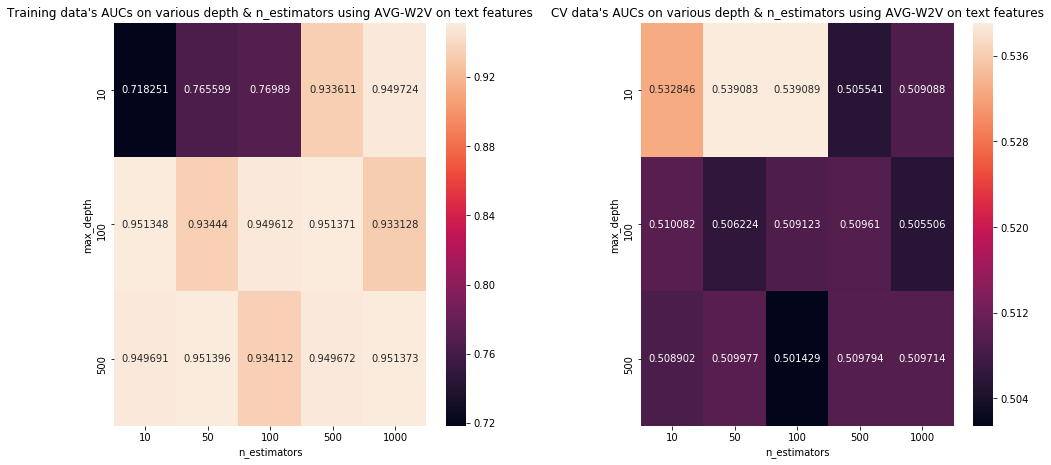

In [0]:
rf_set3_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_avgW2V', 'project_title_text_avgW2V']
rf_plt_title3 = "AVG-W2V"

rf_data_pnts_tr3 = getMergedFeatures(data_dict['X_tr'], rf_set3_cols)
rf_data_pnts_test3 = getMergedFeatures(data_dict['X_test'], rf_set3_cols)

rf_auc_tr3, rf_auc_cv3 = getAUCs(rf_data_pnts_tr3, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr3, rf_auc_cv3, rf_plt_title3)
rf_optimal_alpha3 = (10, 100)
rft3 = trainOnOptimalHP(rf_optimal_alpha3, rf_data_pnts_tr3, y_tr)
rf_roc_data_test3, rf_roc_data_train3 = getROC_Data(rf_data_pnts_test3, y_test, rf_data_pnts_tr3, y_tr, rft3)

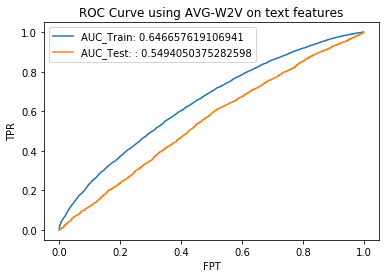

In [0]:
makeROC(rf_roc_data_test3, rf_roc_data_train3, rf_plt_title3)

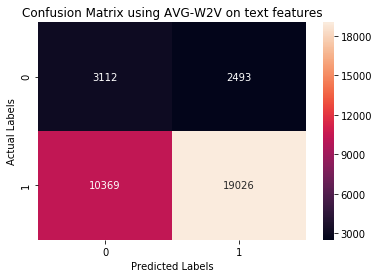

In [0]:
getConfusionMatrix(rft3, rf_data_pnts_tr3, y_tr, rf_plt_title3)

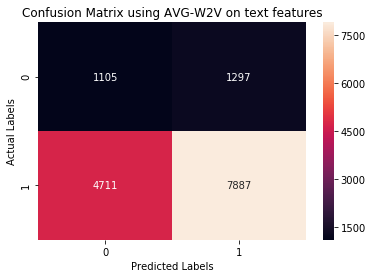

In [0]:
getConfusionMatrix(rft3, rf_data_pnts_test3, y_test, rf_plt_title3)

### Applying RF on TFIDF W2V SET : 4

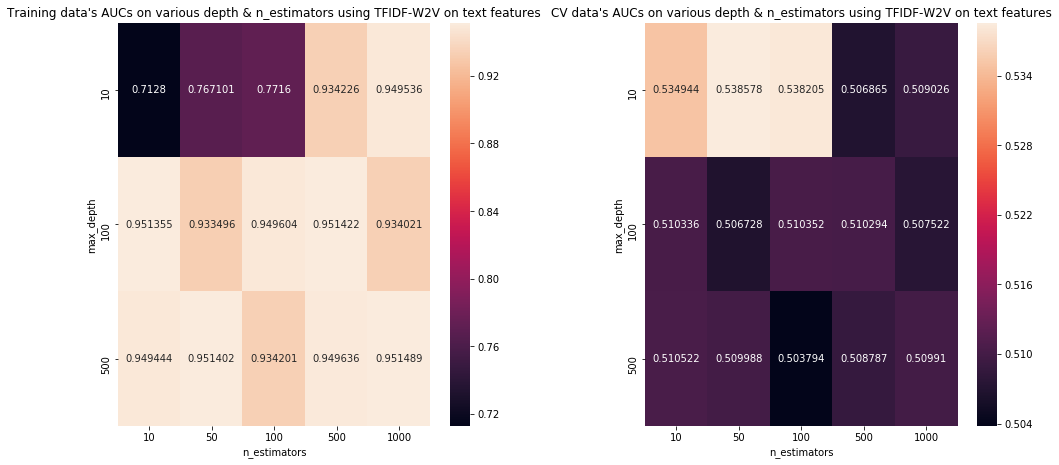

In [0]:
rf_set4_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidfW2V', 'project_title_text_tfidfW2V']
rf_plt_title4 = "TFIDF-W2V"

rf_data_pnts_tr4 = getMergedFeatures(data_dict['X_tr'], rf_set4_cols)
rf_data_pnts_test4 = getMergedFeatures(data_dict['X_test'], rf_set4_cols)

rf_auc_tr4, rf_auc_cv4 = getAUCs(rf_data_pnts_tr4, y_tr, rf_parameters)
plotPerformance3d(rf_n_estimators, rf_max_depths, rf_auc_tr4, rf_auc_cv4, rf_plt_title4)
rf_optimal_alpha4 = (10, 50)
rft4 = trainOnOptimalHP(rf_optimal_alpha4, rf_data_pnts_tr4, y_tr)
rf_roc_data_test4, rf_roc_data_train4 = getROC_Data(rf_data_pnts_test4, y_test, rf_data_pnts_tr4, y_tr, rft4)

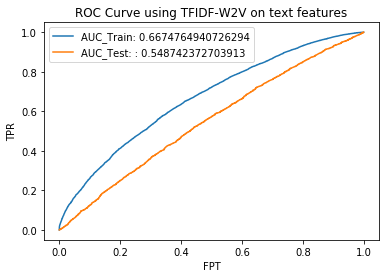

In [0]:
makeROC(rf_roc_data_test4, rf_roc_data_train4, rf_plt_title4)

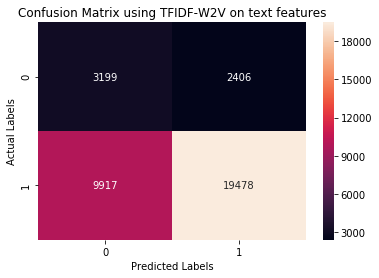

In [0]:
getConfusionMatrix(rft4, rf_data_pnts_tr4, y_tr, rf_plt_title4)

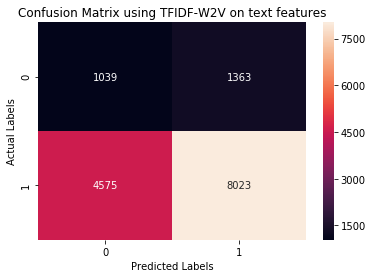

In [0]:
getConfusionMatrix(rft4, rf_data_pnts_test4, y_test, rf_plt_title4)

## Machine Laerning Model : GBDT


1.   we can use 2 models here GBDT from SKlearn 
2.   XG-Boost form XG-boost Library.
3.   I use XG-boost as the implimenation of XG-boost is advanced in many applications in regards to the SK-learn implimentation. 




In [0]:
gbdt_n_estimators = [5, 10]
gbdt_max_depths =  [10, 50, 100, 500, 1000]
gbdt_parameters = {  'max_depth': gbdt_max_depths, 
                    'n_estimators': gbdt_n_estimators }

###  XGBoost on BOW, SET 1

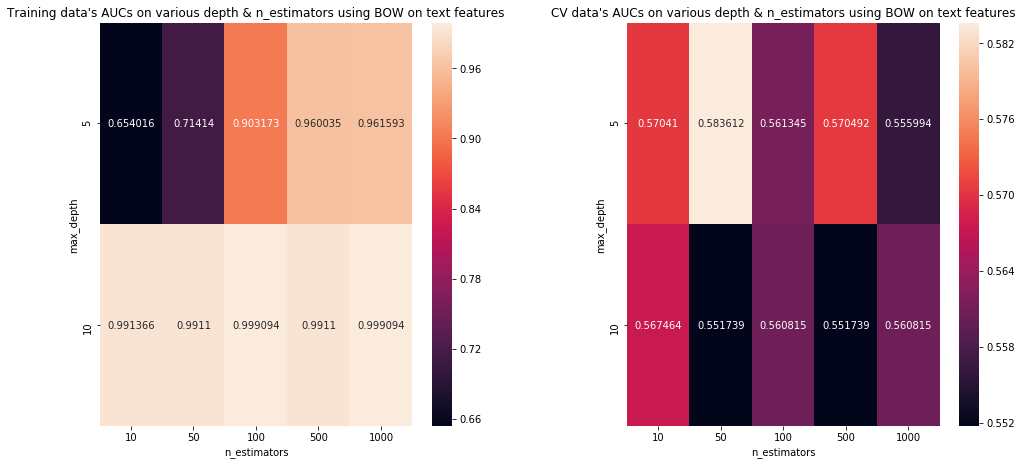

In [0]:
gbdt_set1_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_bow', 'project_title_text_bow']
gbdt_plt_title1 = 'BOW'

gbdt_data_pnts_tr1 = getMergedFeatures(data_dict['X_tr'], gbdt_set1_cols)
gbdt_data_pnts_test1 = getMergedFeatures(data_dict['X_test'], gbdt_set1_cols)

gbdt_auc_tr1, gbdt_auc_cv1 = getAUCs(gbdt_data_pnts_tr1, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr1, gbdt_auc_cv1, gbdt_plt_title1)
gbdt_optimal_hypers1 = (5, 500)
gbdt1 = trainOnOptimalHP(gbdt_optimal_hypers1, gbdt_data_pnts_tr1, y_tr)
gbdt_roc_data_test1, gbdt_roc_data_train1 = getROC_Data(gbdt_data_pnts_test1, y_test, gbdt_data_pnts_tr1, y_tr, gbdt1)

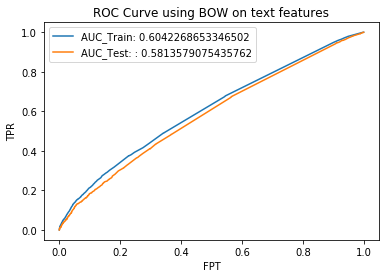

In [0]:
makeROC(gbdt_roc_data_test1, gbdt_roc_data_train1, gbdt_plt_title1)

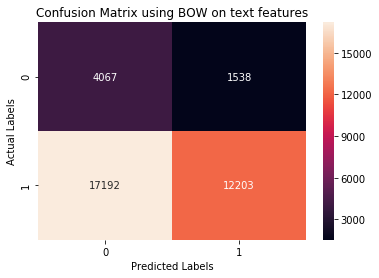

In [0]:
getConfusionMatrix(gbdt1, gbdt_data_pnts_tr1, y_tr, gbdt_plt_title1)

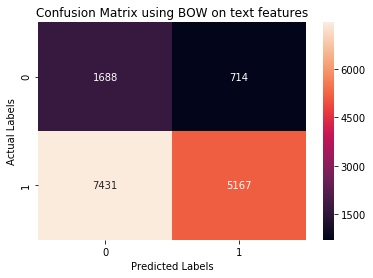

In [0]:
getConfusionMatrix(gbdt1, gbdt_data_pnts_test1, y_test, gbdt_plt_title1)

### XGBoost on TFIDF , SET 2

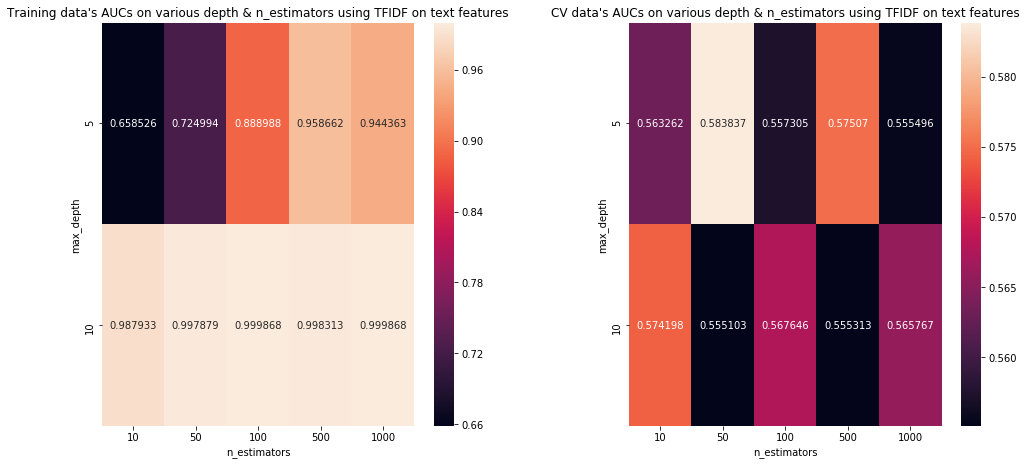

In [0]:
gbdt_set2_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidf', 'project_title_text_tfidf']
gbdt_plt_title2 = 'TFIDF'

gbdt_data_pnts_tr2 = getMergedFeatures(data_dict['X_tr'], gbdt_set2_cols)
gbdt_data_pnts_test2 = getMergedFeatures(data_dict['X_test'], gbdt_set2_cols)

gbdt_auc_tr2, gbdt_auc_cv2 = getAUCs(gbdt_data_pnts_tr2, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr2, gbdt_auc_cv2, gbdt_plt_title2)
gbdt_optimal_hypers2 = (5, 50)
gbdt2 = trainOnOptimalHP(gbdt_optimal_hypers2, gbdt_data_pnts_tr2, y_tr)
gbdt_roc_data_test2, gbdt_roc_data_train2 = getROC_Data(gbdt_data_pnts_test2, y_test, gbdt_data_pnts_tr2, y_tr, gbdt2)

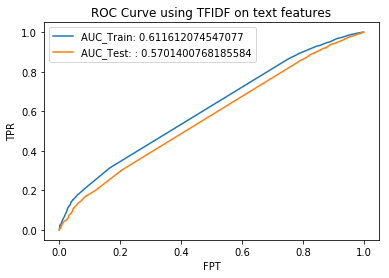

In [0]:
makeROC(gbdt_roc_data_test2, gbdt_roc_data_train2, gbdt_plt_title2)

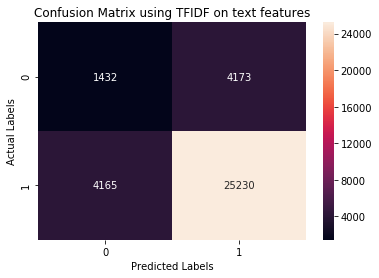

In [0]:
getConfusionMatrix(gbdt2, gbdt_data_pnts_tr2, y_tr, gbdt_plt_title2)

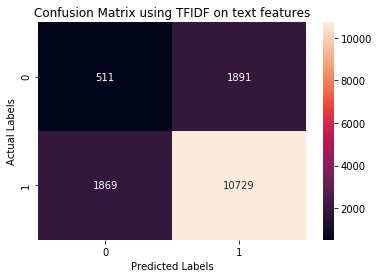

In [0]:
getConfusionMatrix(gbdt2, gbdt_data_pnts_test2, y_test, gbdt_plt_title2)

### XGBOOST on AVG W2V, SET 3

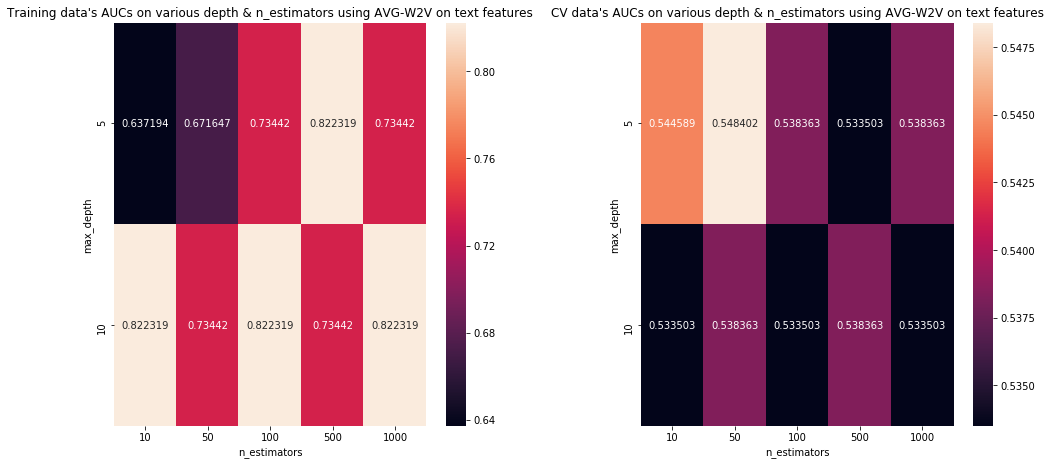

In [0]:
gbdt_set3_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_avgW2V', 'project_title_text_avgW2V']
gbdt_plt_title3 = "AVG-W2V"

gbdt_data_pnts_tr3 = getMergedFeatures(data_dict['X_tr'], gbdt_set3_cols)
gbdt_data_pnts_test3 = getMergedFeatures(data_dict['X_test'], gbdt_set3_cols)

gbdt_auc_tr3, gbdt_auc_cv3 = getAUCs(gbdt_data_pnts_tr3, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr3, gbdt_auc_cv3, gbdt_plt_title3)
gbdt_optimal_hypers3 = (5, 50)
gbdt3 = trainOnOptimalHP(gbdt_optimal_hypers3, gbdt_data_pnts_tr3, y_tr)
gbdt_roc_data_test3, gbdt_roc_data_train3 = getROC_Data(gbdt_data_pnts_test3, y_test, gbdt_data_pnts_tr3, y_tr, gbdt3)

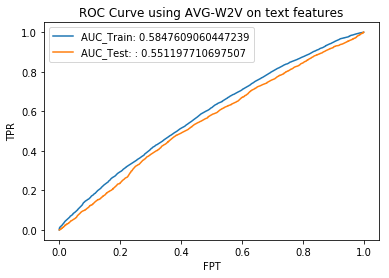

In [0]:
makeROC(gbdt_roc_data_test3, gbdt_roc_data_train3, gbdt_plt_title3)

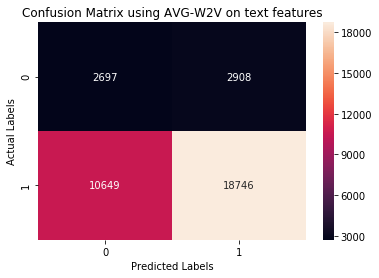

In [0]:
getConfusionMatrix(gbdt3, gbdt_data_pnts_tr3, y_tr, gbdt_plt_title3)

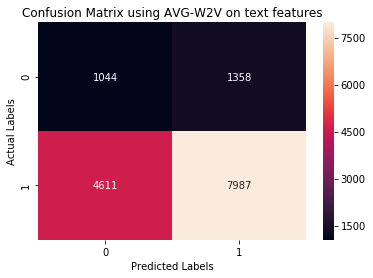

In [0]:
getConfusionMatrix(gbdt3, gbdt_data_pnts_test3, y_test, gbdt_plt_title3)

###  XGBoost on TFIDF W2V, SET 4

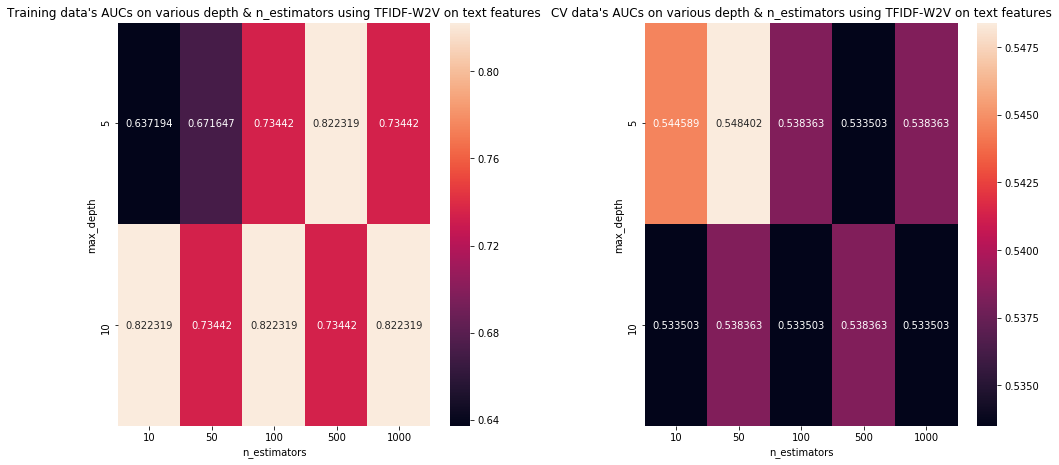

In [0]:
gbdt_set4_cols = ['school_state','clean_categories', 'clean_subcategories', 'project_grade_category', 'teacher_prefix',
             'price', 'teacher_number_of_previously_posted_projects', 
             'essay_text_tfidfW2V', 'project_title_text_tfidfW2V']
gbdt_plt_title4 = "TFIDF-W2V"

gbdt_data_pnts_tr4 = getMergedFeatures(data_dict['X_tr'], gbdt_set4_cols)
gbdt_data_pnts_test4 = getMergedFeatures(data_dict['X_test'], gbdt_set4_cols)

gbdt_auc_tr4, gbdt_auc_cv4 = getAUCs(gbdt_data_pnts_tr4, y_tr, gbdt_parameters, 1)
plotPerformance3d(gbdt_n_estimators, gbdt_max_depths, gbdt_auc_tr4, gbdt_auc_cv4, gbdt_plt_title4)
gbdt_optimal_hypers4 = (5, 50)
gbdt4 = trainOnOptimalHP(gbdt_optimal_hypers4, gbdt_data_pnts_tr4, y_tr)
gbdt_roc_data_test4, gbdt_roc_data_train4 = getROC_Data(gbdt_data_pnts_test4, y_test, gbdt_data_pnts_tr4, y_tr, gbdt4)

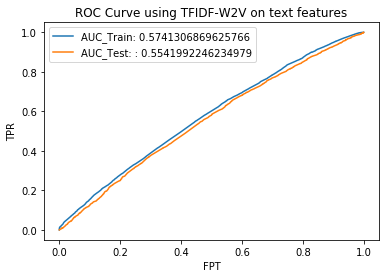

In [0]:
makeROC(gbdt_roc_data_test4, gbdt_roc_data_train4, gbdt_plt_title4)

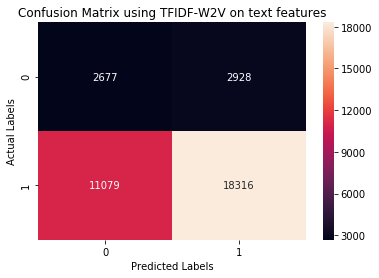

In [0]:
getConfusionMatrix(gbdt4, gbdt_data_pnts_tr4, y_tr, gbdt_plt_title4)

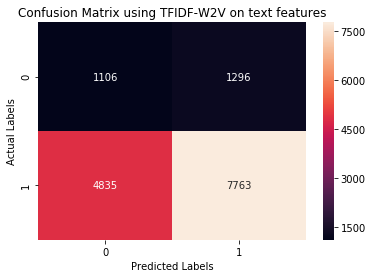

In [0]:
getConfusionMatrix(gbdt4, gbdt_data_pnts_test4, y_test, gbdt_plt_title4)


### Conclusions

In [3]:
#how to use pretty table http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= (" Model ", " Vectorizer ", " Max_depth ", " Min_sample_split "," Test -AUC " , "Train - AUc")
tb.add_row(["Random Forest", " BOW ", 10, 50, 0.60,0.59])
tb.add_row(["Random Forest"," Tf - Idf", 10 , 50 ,0.68,0.58 ])
tb.add_row(["Random Forest"," AVG-W2V", 10, 100,0.64,0.54])
tb.add_row(["Random Forest"," TFIDF_W2V  ", 10, 50,0.66,0.54])

tb.add_row([" XGBoost", " BOW ", 5, 500, 0.68,0.58])
tb.add_row(["XGBoost"," Tf - Idf", 5 , 500 ,0.61,0.57 ])
tb.add_row(["XGBoost"," AVG-W2V", 5, 500,0.58,0.55])
tb.add_row(["XGBoost"," TFIDF_W2V  ", 5, 500,0.57,0.55])





print(tb.get_string(titles = "Decision trees- Observations")) 

+---------------+--------------+-------------+--------------------+-------------+-------------+
|     Model     |  Vectorizer  |  Max_depth  |  Min_sample_split  |  Test -AUC  | Train - AUc |
+---------------+--------------+-------------+--------------------+-------------+-------------+
| Random Forest |     BOW      |      10     |         50         |     0.6     |     0.59    |
| Random Forest |   Tf - Idf   |      10     |         50         |     0.68    |     0.58    |
| Random Forest |    AVG-W2V   |      10     |        100         |     0.64    |     0.54    |
| Random Forest |  TFIDF_W2V   |      10     |         50         |     0.66    |     0.54    |
|     XGBoost   |     BOW      |      5      |        500         |     0.68    |     0.58    |
|    XGBoost    |   Tf - Idf   |      5      |        500         |     0.61    |     0.57    |
|    XGBoost    |    AVG-W2V   |      5      |        500         |     0.58    |     0.55    |
|    XGBoost    |  TFIDF_W2V   |      5 